In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Lambda, Input, MaxPooling2D, Concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns


In [4]:
data_dir = '/content/drive/MyDrive/cyclone_DataSet'
train_dir = data_dir + '/train'
val_dir = data_dir + '/val'
test_dir = data_dir + '/test'


In [5]:
# Data Augmentation and Rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



# Rescaling and resizing to 150x150
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Ensure this matches the model's input size
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),  # Ensure this matches the model's input size
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Ensure this matches the model's input size
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 720 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda, MaxPooling2D, Flatten, Concatenate, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the sum pooling function
def sum_pool(x):
    return tf.reduce_sum(x, axis=(1, 2))

input_layer = Input(shape=(150, 150, 3))

# First convolutional layer with 32 filters, kernel size of 3x3, and ReLU activation
conv_layer1 = Conv2D(32, (3, 3), activation='relu')(input_layer)

# Sum Pooling after the first convolutional layer
pool_layer1 = Lambda(sum_pool)(conv_layer1)

# Second convolutional layer with 64 filters, kernel size of 3x3, and ReLU activation
conv_layer2 = Conv2D(64, (3, 3), activation='relu')(input_layer)

# MaxPooling layer after the second convolutional layer
pool_layer2 = MaxPooling2D(pool_size=(2, 2))(conv_layer2)

# Flattening the pooled features from the first two layers
flat_layer1 = Flatten()(pool_layer1)
flat_layer2 = Flatten()(pool_layer2)

# Concatenating all the features: flatten layers and the pooled layers
concat_layer = Concatenate()([flat_layer1, flat_layer2])

# Adding Dense and Dropout layers
x = Dense(512, activation='relu')(concat_layer)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# Fully connected output layer with sigmoid activation
output_layer = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Define the optimizer with a specific learning rate
learning_rate = 0.001  # Set the learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer and loss function
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 148, 148, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 148, 148, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 32)             │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 74, 74, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 32)             │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 350464)         │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 350496)         │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │    179,454,464 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            129 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 179,621,505 (685.20 MB)

 Trainable params: 179,621,505 (685.20 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 377s 14s/step - accuracy: 0.5591 - loss: 22.6973 - val_accuracy: 0.7458 - val_loss: 0.9447
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.7610 - loss: 1.4182 - val_accuracy: 0.9000 - val_loss: 0.3790
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step - accuracy: 0.9205 - loss: 0.2144 - val_accuracy: 0.9292 - val_loss: 0.1944
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - accuracy: 0.9736 - loss: 0.0808 - val_accuracy: 0.9708 - val_loss: 0.0899
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.9743 - loss: 0.0629 - val_accuracy: 0.9875 - val_loss: 0.0444
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.9942 - loss: 0.0167 - val_accuracy: 0.9917 - val_loss: 0.0487
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.9960 - loss: 0.0159 - val_accuracy: 0.9833 - val_loss: 0.0777
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.9990 - loss: 0.0071 - val_accuracy: 0.9875 - val_loss: 

In [8]:
# Test accuracy
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy:.4f}')

# Train and Validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 108s 15s/step - accuracy: 0.9872 - loss: 0.0671
Test Accuracy: 0.9875
Train Accuracy: 0.9986
Validation Accuracy: 0.9875


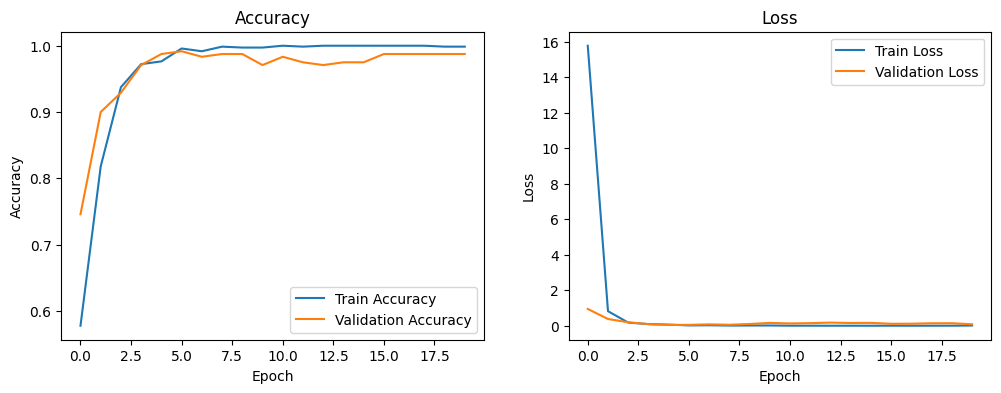

In [9]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Classification Report:
              precision    recall  f1-score   support

     Cyclone       0.98      0.99      0.99       120
  No Cyclone       0.99      0.98      0.99       120

    accuracy                           0.99       240
   macro avg       0.99      0.99      0.99       240
weighted avg       0.99      0.99      0.99       240

Precision: 0.9835
Recall: 0.9917
F1 Score: 0.9876
AUC: 0.9986


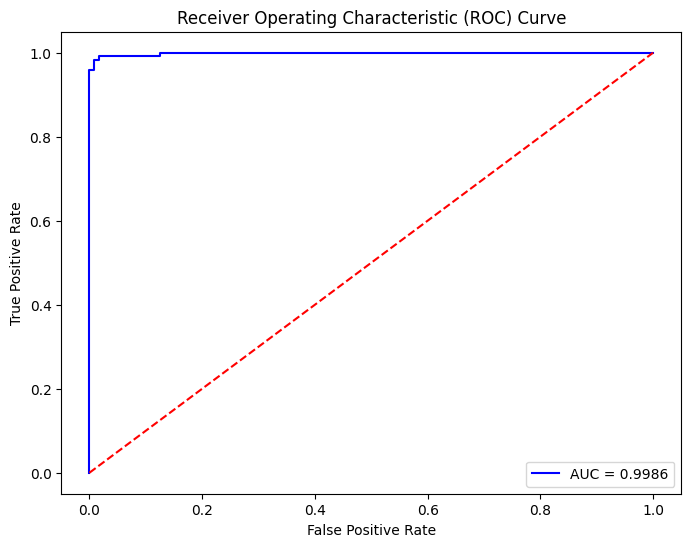

In [10]:
# Import necessary libraries for ROC and AUC
from sklearn.metrics import roc_curve, roc_auc_score

# Get true labels and predictions
test_generator.reset()
predictions = model.predict(test_generator)

# Convert predictions to binary outcomes
predicted_classes = (predictions > 0.5).astype(int)
true_classes = test_generator.classes

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=['Cyclone', 'No Cyclone'], output_dict=True)

print('Classification Report:')
print(classification_report(true_classes, predicted_classes, target_names=['Cyclone', 'No Cyclone']))

# Precision, Recall, F1 Score
precision = report['Cyclone']['precision']
recall = report['Cyclone']['recall']
f1_score = report['Cyclone']['f1-score']

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

# Calculate ROC AUC
auc = roc_auc_score(true_classes, predictions)
print(f'AUC: {auc:.4f}')

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(true_classes, predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


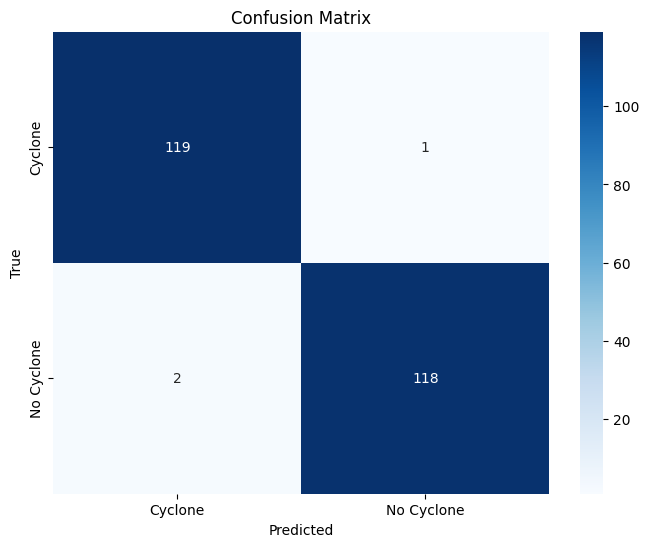

In [11]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cyclone', 'No Cyclone'], yticklabels=['Cyclone', 'No Cyclone'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
